# Regression Model for NCAA Women's Volleyball Win-Loss Percentages Using Python and Scikit-learn
### David Lowe
### May 7, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The NCAA Women's Volleyball dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: NCAA maintains and publishes numerous datasets on its sporting events and statistics. The goal of this exercise is to experiment with the non-neural-network machine learning (ML) algorithms and observe whether we can use those classic ML techniques to model the sport of volleyball.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average RMSE of 0.0762. Two algorithms (Ridge Regression and Extra Trees) reached the top RMSE metrics after the first round of modeling. After a series of tuning trials, Ridge Regression turned a better overall result than Extra Trees. Ridge Regression achieved an RMSE metric of 0.0661. By using the optimized parameters, the Gradient Boosting algorithm processed the test dataset with an RMSE of 0.0643, which was slightly better than the prediction from the training data.

CONCLUSION: For this iteration, the Ridge Regression algorithm achieved the best overall results using the training and testing datasets. For this dataset, we should consider using Ridge Regression for more modeling and testing.

Dataset Used: NCAA Women's Volleyball Archived Statistics

Dataset ML Model: Regression with numerical attributes

Dataset Reference: http://web1.ncaa.org/stats/StatsSrv/rankings?doWhat=archive&sportCode=WVB

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
# import shutil
# import urllib.request
# import zipfile
import smtplib
# import re
from datetime import datetime
from email.message import EmailMessage
# from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN
# from imblearn.combine import SMOTETomek

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor

### 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'neg_mean_squared_error'

In [9]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if (sender is None) or (receiver is None) or (gateway is None) or (smtpuser is None) or (password is None):
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Regression Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [10]:
if notifyStatus: email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
# Aces Per Set
df01 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_01.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df01.drop(columns=['Rank', 'W-L'], inplace=True)
df01.dropna(axis=0, how='all', inplace=True)
df01.rename(columns={"S": "Sets", "Per Set": "Aces_Per_Set"}, inplace=True)

# Assists Per Set
df02 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_02.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df02.drop(columns=['Rank', 'S', 'W-L'], inplace=True)
df02.dropna(axis=0, how='all', inplace=True)
df02.rename(columns={"Per Set": "Assists_Per_Set"}, inplace=True)

# Blocks Per Set
df03 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_03.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df03.dropna(axis=0, how='all', inplace=True)
df03['Total_Blocks'] = df03['Block Solos'] + (df03['Block Assists'] / 2)
df03.drop(columns=['Rank', 'S', 'W-L'], inplace=True)
df03.rename(columns={"Block Solos": "Block_Solos", "Block Assists": "Block_Assists", "Per Set": "Blocks_Per_Set"}, inplace=True)

# Digs Per Set
df04 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_04.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df04.drop(columns=['Rank', 'S', 'W-L'], inplace=True)
df04.dropna(axis=0, how='all', inplace=True)
df04.rename(columns={"Per Set": "Digs_Per_Set"}, inplace=True)

# Attacks, Errors, and Hitting Percentage
df05 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_05.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df05.dropna(axis=0, how='all', inplace=True)
df05['Attack_Per_Set'] = df05['Total Attacks'] / df05['S']
df05.drop(columns=['Rank', 'S', 'W-L', 'Kills'], inplace=True)
df05.rename(columns={"Errors": "Team_Errors", "Total Attacks": "Team_Attacks", "Pct.": "Team_Hit_Pct"}, inplace=True)

# Kills Per Set
df06 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_06.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df06.drop(columns=['Rank', 'S', 'W-L'], inplace=True)
df06.dropna(axis=0, how='all', inplace=True)
df06.rename(columns={"Kills": "Team_Kills", "Per Set": "Kills_Per_Set"}, inplace=True)

# Match W-L Percentage
df07 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_07.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df07.drop(columns=['Rank'], inplace=True)
df07.dropna(axis=0, how='all', inplace=True)
df07.rename(columns={"W": "Wins", "L": "Losses", "Pct.": "Win_Pct"}, inplace=True)

# Opponent Hitting Percentage
df08 = pd.read_csv('https://dainesanalytics.com/datasets/ncaa-women-volleyball-2019-2020/WVB_2019-20_d1_08.csv', engine='python', skiprows=3, header=3, skipfooter=11)
df08.drop(columns=['Rank', 'S'], inplace=True)
df08.dropna(axis=0, how='all', inplace=True)
df08.rename(columns={"Opp Kills": "Opp_Kills", "Opp Errors": "Opp_Errors", "Opp Attacks": "Opp_Attacks", "Opp Pct": "Opp_Hit_Pct"}, inplace=True)

# Merge sub-tables into the main table
Xy_original = pd.merge(df07, df01, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df02, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df03, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df04, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df05, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df06, on=['Name', 'Name'])
Xy_original = pd.merge(Xy_original, df08, on=['Name', 'Name'])

# Take a peek at the dataframe after import
Xy_original.head(10)

,Name,Wins,Losses,Win_Pct,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
0,SFA,31.0,2.0,0.939,114.0,148.0,1.30,1343.0,11.78,72.0,...,406.0,4168.0,0.258,36.561404,1481.0,12.99,1457.0,760.0,4628.0,0.151
1,Western Ky.,31.0,2.0,0.939,114.0,211.0,1.85,1440.0,12.63,75.0,...,448.0,3626.0,0.304,31.807018,1550.0,13.60,1220.0,656.0,3668.0,0.154
2,Pittsburgh,30.0,2.0,0.938,111.0,156.0,1.41,1517.0,13.67,33.0,...,562.0,3851.0,0.277,34.693694,1627.0,14.66,1188.0,641.0,3692.0,0.148
3,Baylor,29.0,2.0,0.935,104.0,116.0,1.12,1421.0,13.66,42.0,...,500.0,3498.0,0.291,33.634615,1518.0,14.60,1208.0,622.0,3561.0,0.165
4,Colorado St.,29.0,2.0,0.935,110.0,182.0,1.65,1419.0,12.90,75.0,...,512.0,3490.0,0.285,31.727273,1508.0,13.71,1054.0,667.0,3482.0,0.111
5,South Dakota,31.0,3.0,0.912,123.0,178.0,1.45,1652.0,13.43,46.0,...,600.0,4392.0,0.265,35.707317,1762.0,14.33,1383.0,693.0,4422.0,0.156
6,Towson,29.0,3.0,0.906,112.0,161.0,1.44,1491.0,13.31,26.0,...,546.0,3929.0,0.269,35.080357,1604.0,14.32,1240.0,651.0,3951.0,0.149
7,Stanford,30.0,4.0,0.882,120.0,162.0,1.35,1674.0,13.95,30.0,...,502.0,4236.0,0.302,35.300000,1780.0,14.83,1436.0,678.0,4304.0,0.176
8,New Mexico St.,27.0,4.0,0.871,108.0,153.0,1.42,1354.0,12.54,65.0,...,529.0,3590.0,0.262,33.240741,1470.0,13.61,1113.0,682.0,3558.0,0.121
9,Hawaii,26.0,4.0,0.867,114.0,156.0,1.37,1428.0,12.53,66.0,...,548.0,4036.0,0.249,35.403509,1553.0,13.62,1338.0,662.0,4014.0,0.168


In [12]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             335 non-null    object 
 1   Wins             335 non-null    float64
 2   Losses           335 non-null    float64
 3   Win_Pct          335 non-null    float64
 4   Sets             335 non-null    float64
 5   Aces             335 non-null    float64
 6   Aces_Per_Set     335 non-null    float64
 7   Assists          335 non-null    float64
 8   Assists_Per_Set  335 non-null    float64
 9   Block_Solos      335 non-null    float64
 10  Block_Assists    335 non-null    float64
 11  Blocks_Per_Set   335 non-null    float64
 12  Total_Blocks     335 non-null    float64
 13  Digs             335 non-null    float64
 14  Digs_Per_Set     335 non-null    float64
 15  Team_Errors      335 non-null    float64
 16  Team_Attacks     335 non-null    float64
 17  Team_Hit_Pct    

In [13]:
Xy_original.describe()

,Wins,Losses,Win_Pct,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,Block_Assists,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.00000,335.000000,335.000000,335.000000,...,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,14.997015,14.970149,0.494487,111.755224,148.608955,1.326627,1290.21194,11.509761,50.179104,353.791045,...,588.871642,3916.134328,0.204433,34.998666,1393.137313,12.428866,1392.659701,588.805970,3916.059701,0.206543
std,6.594090,5.736662,0.200688,10.773655,30.983083,0.226591,198.63768,1.133987,17.439824,92.662955,...,79.863234,468.155212,0.040488,1.862970,209.869304,1.167305,147.878482,82.159411,467.170918,0.028195
min,0.000000,2.000000,0.000000,74.000000,77.000000,0.730000,584.00000,7.120000,16.000000,120.000000,...,334.000000,2257.000000,0.049000,27.524390,635.000000,7.740000,931.000000,260.000000,2188.000000,0.111000
25%,10.000000,11.000000,0.367000,106.000000,126.000000,1.150000,1164.00000,10.900000,37.000000,288.000000,...,533.500000,3637.000000,0.181000,33.753412,1261.500000,11.815000,1301.000000,538.000000,3640.500000,0.190000
50%,14.000000,15.000000,0.483000,112.000000,145.000000,1.300000,1308.00000,11.640000,48.000000,344.000000,...,590.000000,3927.000000,0.203000,35.066667,1421.000000,12.520000,1393.000000,584.000000,3925.000000,0.209000
75%,20.000000,19.000000,0.636000,118.000000,170.000000,1.475000,1420.00000,12.225000,61.000000,412.000000,...,638.500000,4212.000000,0.229000,36.090914,1529.000000,13.190000,1477.500000,644.000000,4180.000000,0.223000
max,31.000000,31.000000,0.939000,142.000000,263.000000,2.070000,1775.00000,14.200000,108.000000,630.000000,...,794.000000,5231.000000,0.325000,39.873950,1909.000000,15.110000,1859.000000,850.000000,5162.000000,0.321000


In [14]:
Xy_original.isnull().sum()

Name               0
Wins               0
Losses             0
Win_Pct            0
Sets               0
Aces               0
Aces_Per_Set       0
Assists            0
Assists_Per_Set    0
Block_Solos        0
Block_Assists      0
Blocks_Per_Set     0
Total_Blocks       0
Digs               0
Digs_Per_Set       0
Team_Errors        0
Team_Attacks       0
Team_Hit_Pct       0
Attack_Per_Set     0
Team_Kills         0
Kills_Per_Set      0
Opp_Kills          0
Opp_Errors         0
Opp_Attacks        0
Opp_Hit_Pct        0
dtype: int64

In [15]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [16]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'Win_Pct': 'targetVar'})

# Dropping features
Xy_original.drop(columns=['Name','Wins','Losses'], inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,targetVar,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,Block_Assists,Blocks_Per_Set,Total_Blocks,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
0,0.939,114.0,148.0,1.30,1343.0,11.78,72.0,497.0,2.81,320.5,...,406.0,4168.0,0.258,36.561404,1481.0,12.99,1457.0,760.0,4628.0,0.151
1,0.939,114.0,211.0,1.85,1440.0,12.63,75.0,346.0,2.18,248.0,...,448.0,3626.0,0.304,31.807018,1550.0,13.60,1220.0,656.0,3668.0,0.154
2,0.938,111.0,156.0,1.41,1517.0,13.67,33.0,484.0,2.48,275.0,...,562.0,3851.0,0.277,34.693694,1627.0,14.66,1188.0,641.0,3692.0,0.148
3,0.935,104.0,116.0,1.12,1421.0,13.66,42.0,444.0,2.54,264.0,...,500.0,3498.0,0.291,33.634615,1518.0,14.60,1208.0,622.0,3561.0,0.165
4,0.935,110.0,182.0,1.65,1419.0,12.90,75.0,497.0,2.94,323.5,...,512.0,3490.0,0.285,31.727273,1508.0,13.71,1054.0,667.0,3482.0,0.111
5,0.912,123.0,178.0,1.45,1652.0,13.43,46.0,514.0,2.46,303.0,...,600.0,4392.0,0.265,35.707317,1762.0,14.33,1383.0,693.0,4422.0,0.156
6,0.906,112.0,161.0,1.44,1491.0,13.31,26.0,527.0,2.58,289.5,...,546.0,3929.0,0.269,35.080357,1604.0,14.32,1240.0,651.0,3951.0,0.149
7,0.882,120.0,162.0,1.35,1674.0,13.95,30.0,630.0,2.88,345.0,...,502.0,4236.0,0.302,35.300000,1780.0,14.83,1436.0,678.0,4304.0,0.176
8,0.871,108.0,153.0,1.42,1354.0,12.54,65.0,495.0,2.89,312.5,...,529.0,3590.0,0.262,33.240741,1470.0,13.61,1113.0,682.0,3558.0,0.121
9,0.867,114.0,156.0,1.37,1428.0,12.53,66.0,471.0,2.64,301.5,...,548.0,4036.0,0.249,35.403509,1553.0,13.62,1338.0,662.0,4014.0,0.168


In [17]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   targetVar        335 non-null    float64
 1   Sets             335 non-null    float64
 2   Aces             335 non-null    float64
 3   Aces_Per_Set     335 non-null    float64
 4   Assists          335 non-null    float64
 5   Assists_Per_Set  335 non-null    float64
 6   Block_Solos      335 non-null    float64
 7   Block_Assists    335 non-null    float64
 8   Blocks_Per_Set   335 non-null    float64
 9   Total_Blocks     335 non-null    float64
 10  Digs             335 non-null    float64
 11  Digs_Per_Set     335 non-null    float64
 12  Team_Errors      335 non-null    float64
 13  Team_Attacks     335 non-null    float64
 14  Team_Hit_Pct     335 non-null    float64
 15  Attack_Per_Set   335 non-null    float64
 16  Team_Kills       335 non-null    float64
 17  Kills_Per_Set   

In [18]:
Xy_original.describe()

,targetVar,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,Block_Assists,Blocks_Per_Set,Total_Blocks,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
count,335.000000,335.000000,335.000000,335.000000,335.00000,335.000000,335.000000,335.000000,335.000000,335.000000,...,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,0.494487,111.755224,148.608955,1.326627,1290.21194,11.509761,50.179104,353.791045,2.028090,227.074627,...,588.871642,3916.134328,0.204433,34.998666,1393.137313,12.428866,1392.659701,588.805970,3916.059701,0.206543
std,0.200688,10.773655,30.983083,0.226591,198.63768,1.133987,17.439824,92.662955,0.377804,49.201807,...,79.863234,468.155212,0.040488,1.862970,209.869304,1.167305,147.878482,82.159411,467.170918,0.028195
min,0.000000,74.000000,77.000000,0.730000,584.00000,7.120000,16.000000,120.000000,0.970000,76.000000,...,334.000000,2257.000000,0.049000,27.524390,635.000000,7.740000,931.000000,260.000000,2188.000000,0.111000
25%,0.367000,106.000000,126.000000,1.150000,1164.00000,10.900000,37.000000,288.000000,1.775000,194.500000,...,533.500000,3637.000000,0.181000,33.753412,1261.500000,11.815000,1301.000000,538.000000,3640.500000,0.190000
50%,0.483000,112.000000,145.000000,1.300000,1308.00000,11.640000,48.000000,344.000000,2.030000,224.000000,...,590.000000,3927.000000,0.203000,35.066667,1421.000000,12.520000,1393.000000,584.000000,3925.000000,0.209000
75%,0.636000,118.000000,170.000000,1.475000,1420.00000,12.225000,61.000000,412.000000,2.245000,255.750000,...,638.500000,4212.000000,0.229000,36.090914,1529.000000,13.190000,1477.500000,644.000000,4180.000000,0.223000
max,0.939000,142.000000,263.000000,2.070000,1775.00000,14.200000,108.000000,630.000000,3.180000,356.500000,...,794.000000,5231.000000,0.325000,39.873950,1909.000000,15.110000,1859.000000,850.000000,5162.000000,0.321000


In [19]:
Xy_original.isnull().sum()

targetVar          0
Sets               0
Aces               0
Aces_Per_Set       0
Assists            0
Assists_Per_Set    0
Block_Solos        0
Block_Assists      0
Blocks_Per_Set     0
Total_Blocks       0
Digs               0
Digs_Per_Set       0
Team_Errors        0
Team_Attacks       0
Team_Hit_Pct       0
Attack_Per_Set     0
Team_Kills         0
Kills_Per_Set      0
Opp_Kills          0
Opp_Errors         0
Opp_Attacks        0
Opp_Hit_Pct        0
dtype: int64

In [20]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [21]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [22]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (335, 22) X_original.shape: (335, 21) y_original.shape: (335,)


### 1.f) Set up the parameters for data visualization

In [23]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [24]:
if notifyStatus: email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [25]:
if notifyStatus: email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [26]:
X_original.head(10)

,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,Block_Assists,Blocks_Per_Set,Total_Blocks,Digs,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
0,114.0,148.0,1.30,1343.0,11.78,72.0,497.0,2.81,320.5,2015.0,...,406.0,4168.0,0.258,36.561404,1481.0,12.99,1457.0,760.0,4628.0,0.151
1,114.0,211.0,1.85,1440.0,12.63,75.0,346.0,2.18,248.0,1622.0,...,448.0,3626.0,0.304,31.807018,1550.0,13.60,1220.0,656.0,3668.0,0.154
2,111.0,156.0,1.41,1517.0,13.67,33.0,484.0,2.48,275.0,1602.0,...,562.0,3851.0,0.277,34.693694,1627.0,14.66,1188.0,641.0,3692.0,0.148
3,104.0,116.0,1.12,1421.0,13.66,42.0,444.0,2.54,264.0,1501.0,...,500.0,3498.0,0.291,33.634615,1518.0,14.60,1208.0,622.0,3561.0,0.165
4,110.0,182.0,1.65,1419.0,12.90,75.0,497.0,2.94,323.5,1467.0,...,512.0,3490.0,0.285,31.727273,1508.0,13.71,1054.0,667.0,3482.0,0.111
5,123.0,178.0,1.45,1652.0,13.43,46.0,514.0,2.46,303.0,2046.0,...,600.0,4392.0,0.265,35.707317,1762.0,14.33,1383.0,693.0,4422.0,0.156
6,112.0,161.0,1.44,1491.0,13.31,26.0,527.0,2.58,289.5,1787.0,...,546.0,3929.0,0.269,35.080357,1604.0,14.32,1240.0,651.0,3951.0,0.149
7,120.0,162.0,1.35,1674.0,13.95,30.0,630.0,2.88,345.0,1839.0,...,502.0,4236.0,0.302,35.300000,1780.0,14.83,1436.0,678.0,4304.0,0.176
8,108.0,153.0,1.42,1354.0,12.54,65.0,495.0,2.89,312.5,1504.0,...,529.0,3590.0,0.262,33.240741,1470.0,13.61,1113.0,682.0,3558.0,0.121
9,114.0,156.0,1.37,1428.0,12.53,66.0,471.0,2.64,301.5,1687.0,...,548.0,4036.0,0.249,35.403509,1553.0,13.62,1338.0,662.0,4014.0,0.168


#### 2.a.ii) Dimensions and attribute types

In [27]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sets             335 non-null    float64
 1   Aces             335 non-null    float64
 2   Aces_Per_Set     335 non-null    float64
 3   Assists          335 non-null    float64
 4   Assists_Per_Set  335 non-null    float64
 5   Block_Solos      335 non-null    float64
 6   Block_Assists    335 non-null    float64
 7   Blocks_Per_Set   335 non-null    float64
 8   Total_Blocks     335 non-null    float64
 9   Digs             335 non-null    float64
 10  Digs_Per_Set     335 non-null    float64
 11  Team_Errors      335 non-null    float64
 12  Team_Attacks     335 non-null    float64
 13  Team_Hit_Pct     335 non-null    float64
 14  Attack_Per_Set   335 non-null    float64
 15  Team_Kills       335 non-null    float64
 16  Kills_Per_Set    335 non-null    float64
 17  Opp_Kills       

#### 2.a.iii) Statistical summary of the attributes

In [28]:
X_original.describe()

,Sets,Aces,Aces_Per_Set,Assists,Assists_Per_Set,Block_Solos,Block_Assists,Blocks_Per_Set,Total_Blocks,Digs,...,Team_Errors,Team_Attacks,Team_Hit_Pct,Attack_Per_Set,Team_Kills,Kills_Per_Set,Opp_Kills,Opp_Errors,Opp_Attacks,Opp_Hit_Pct
count,335.000000,335.000000,335.000000,335.00000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,...,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,111.755224,148.608955,1.326627,1290.21194,11.509761,50.179104,353.791045,2.028090,227.074627,1654.859701,...,588.871642,3916.134328,0.204433,34.998666,1393.137313,12.428866,1392.659701,588.805970,3916.059701,0.206543
std,10.773655,30.983083,0.226591,198.63768,1.133987,17.439824,92.662955,0.377804,49.201807,252.548261,...,79.863234,468.155212,0.040488,1.862970,209.869304,1.167305,147.878482,82.159411,467.170918,0.028195
min,74.000000,77.000000,0.730000,584.00000,7.120000,16.000000,120.000000,0.970000,76.000000,792.000000,...,334.000000,2257.000000,0.049000,27.524390,635.000000,7.740000,931.000000,260.000000,2188.000000,0.111000
25%,106.000000,126.000000,1.150000,1164.00000,10.900000,37.000000,288.000000,1.775000,194.500000,1499.500000,...,533.500000,3637.000000,0.181000,33.753412,1261.500000,11.815000,1301.000000,538.000000,3640.500000,0.190000
50%,112.000000,145.000000,1.300000,1308.00000,11.640000,48.000000,344.000000,2.030000,224.000000,1645.000000,...,590.000000,3927.000000,0.203000,35.066667,1421.000000,12.520000,1393.000000,584.000000,3925.000000,0.209000
75%,118.000000,170.000000,1.475000,1420.00000,12.225000,61.000000,412.000000,2.245000,255.750000,1807.000000,...,638.500000,4212.000000,0.229000,36.090914,1529.000000,13.190000,1477.500000,644.000000,4180.000000,0.223000
max,142.000000,263.000000,2.070000,1775.00000,14.200000,108.000000,630.000000,3.180000,356.500000,2368.000000,...,794.000000,5231.000000,0.325000,39.873950,1909.000000,15.110000,1859.000000,850.000000,5162.000000,0.321000


### 2.b) Data Visualization

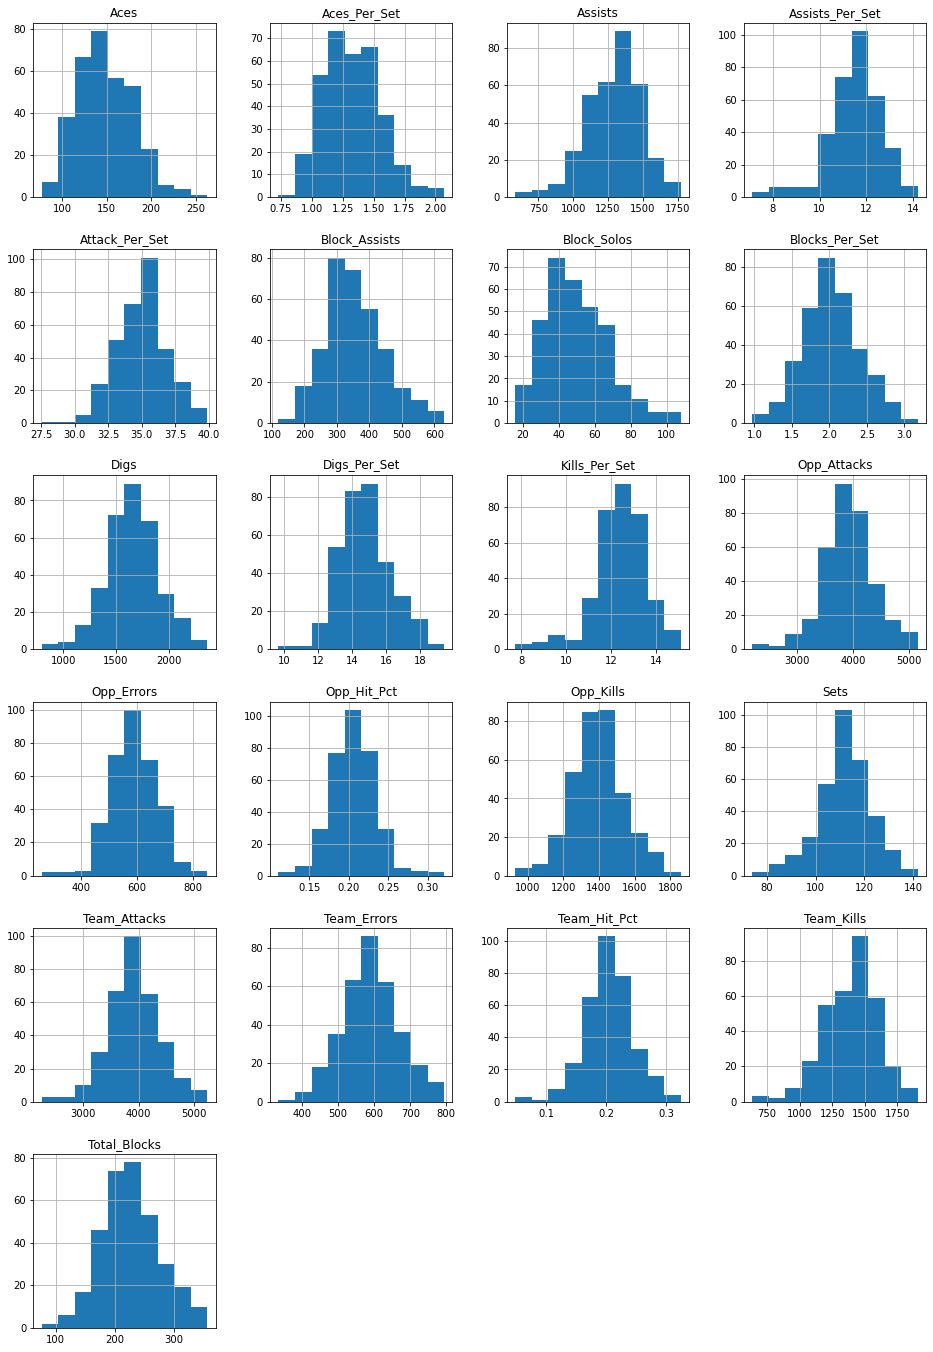

In [29]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

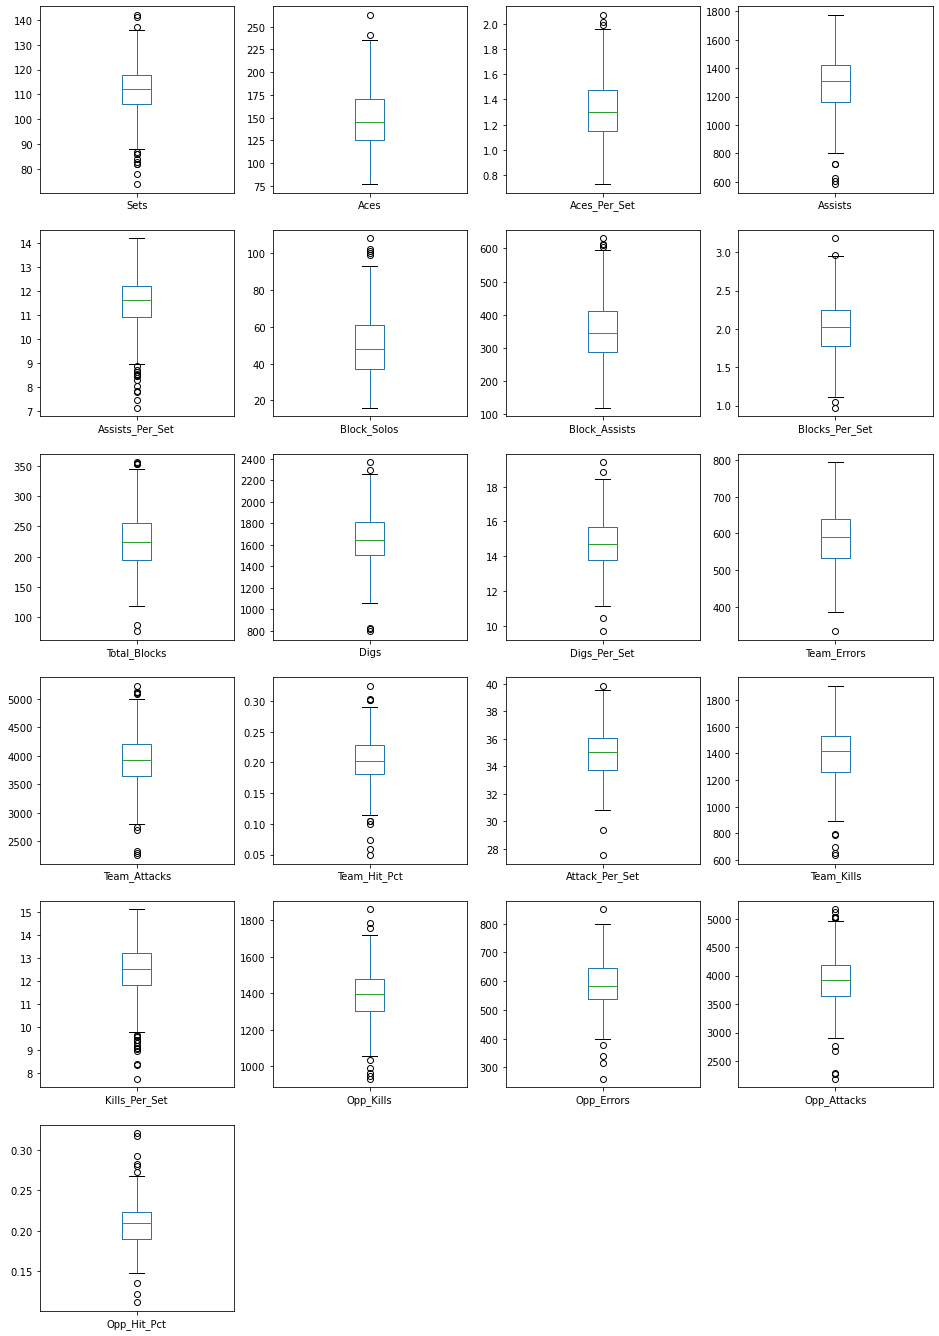

In [30]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

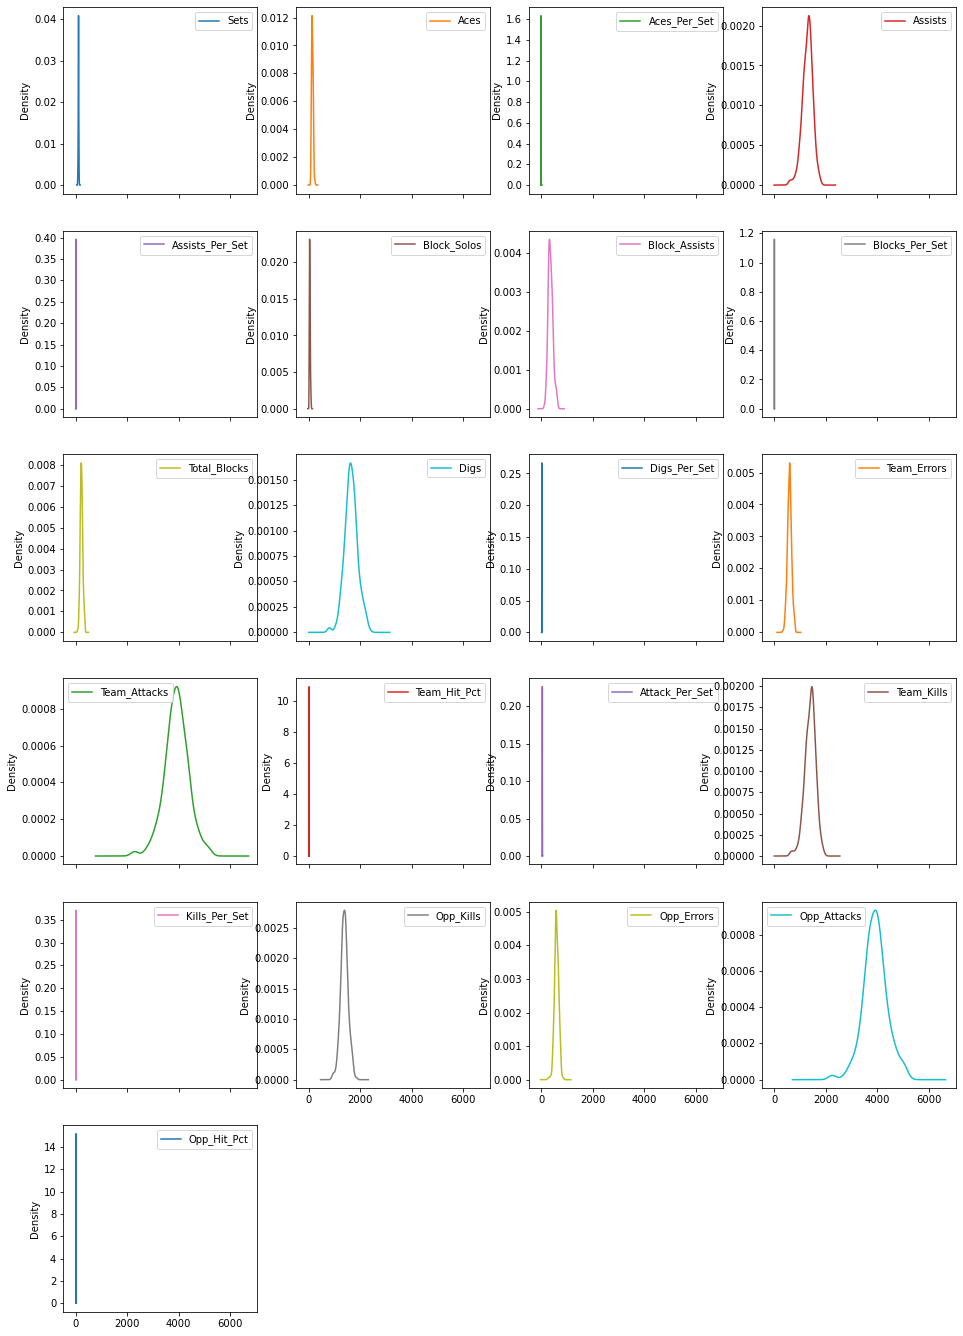

In [31]:
# Density plot for each attribute
X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
plt.show()

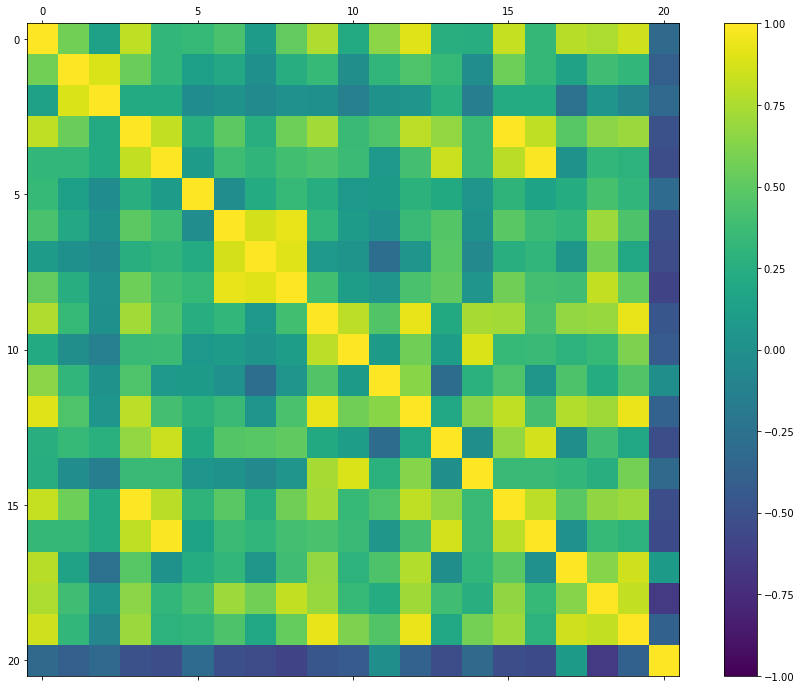

In [32]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [33]:
if notifyStatus: email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [34]:
if notifyStatus: email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [35]:
# Not applicable for this iteration of the project
# Perform one-hot-encoding on the categorical attributes
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [36]:
# Split the data further into training and test datasets
if splitDataset:
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (251, 21) y_train_df.shape: (251,)
X_test_df.shape: (84, 21) y_test_df.shape: (84,)


### 3.b) Feature Scaling and Data Pre-Processing

In [37]:
# Apply feature scaling techniques

X_original = X_original.astype(float)
# X_original['some_feature'] = preprocessing.scale(X_original['some_feature'])
preprocessing.scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.minmax_scale(X_original['some_feature'])
# preprocessing.minmax_scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.normalize(X_original['some_feature'])
# preprocessing.normalize(X_original, copy=False)
# X_original['some_feature'] = preprocessing.robust_scale(X_original['some_feature'])
# preprocessing.robust_scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.power_transform(X_original['some_feature'])
# preprocessing.power_transform(X_original, copy=False)
print(X_original.head(-10))

         Sets      Aces  Aces_Per_Set   Assists  Assists_Per_Set  Block_Solos  \
0    0.208670 -0.019684     -0.117687  0.266148         0.238665     1.253082   
1    0.208670  2.016726      2.313228  0.755205         0.989354     1.425360   
2   -0.070204  0.238908      0.368496  1.143425         1.907845    -0.986524   
3   -0.720909 -1.054051     -0.913259  0.659410         1.899013    -0.469692   
4   -0.163162  1.079331      1.429259  0.649327         1.227809     1.425360   
..        ...       ...           ...       ...              ...          ...   
320 -2.580066 -1.409614     -0.338679 -2.829531        -2.499143    -0.125137   
321 -0.349078 -0.375247     -0.250282 -2.461478        -3.603097    -0.641969   
322 -1.743445 -1.021727     -0.294480 -2.164010        -1.986908    -1.503356   
323 -0.534993 -0.472219     -0.294480 -1.216148        -1.421683    -0.297414   
324 -0.906825 -1.732854     -1.753029 -0.984224        -0.679825    -1.043950   

     Block_Assists  Blocks_

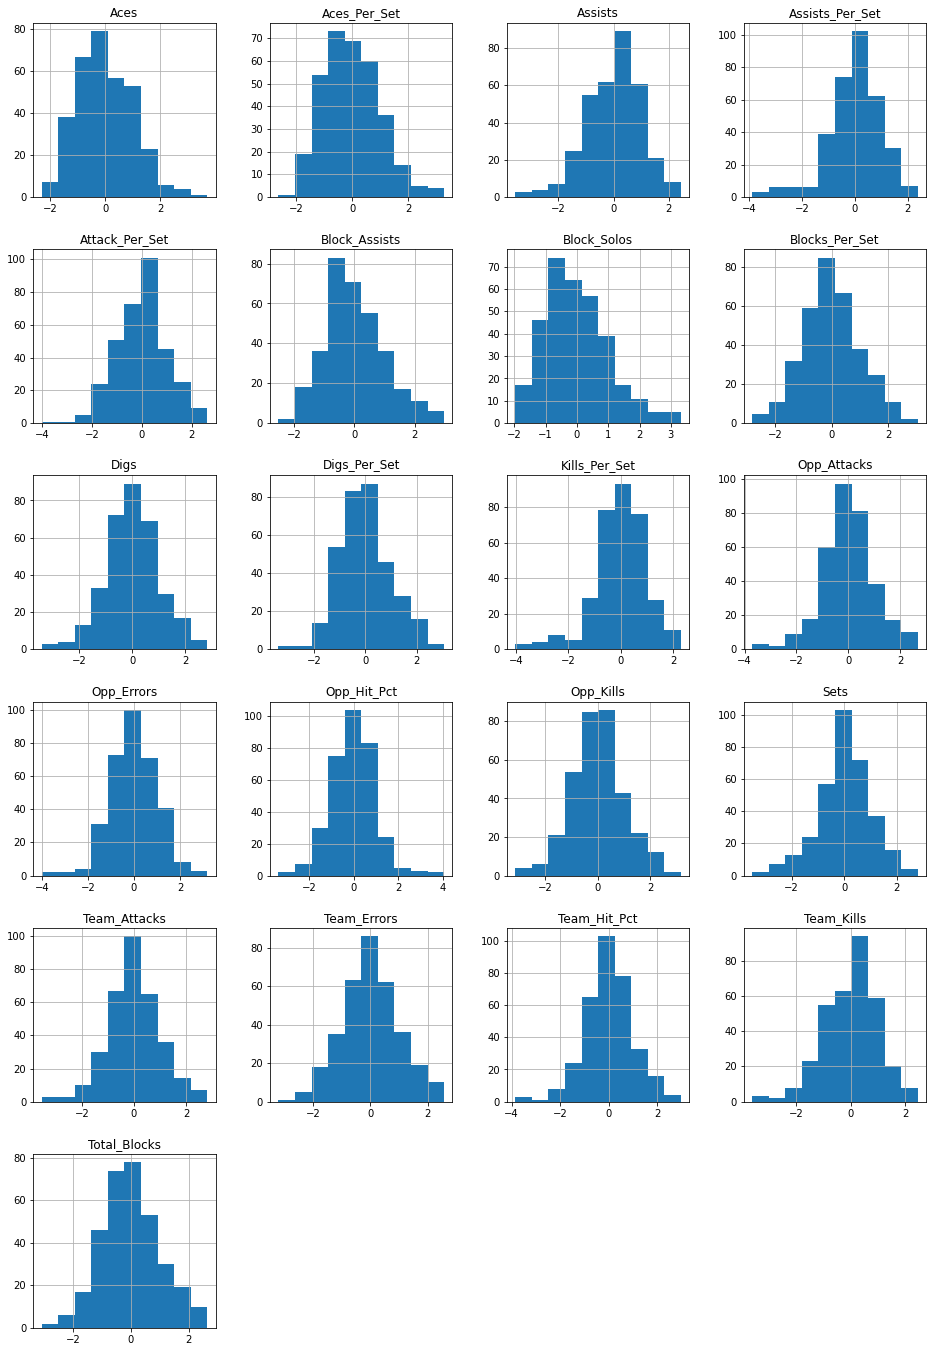

In [38]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

### 3.c) Training Data Balancing

In [39]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [40]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [41]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (251, 21) y_train.shape: (251,)
X_test.shape: (84, 21) y_test.shape: (84,)


In [42]:
if notifyStatus: email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate four linear, two non-linear, and four ensemble algorithms:

Linear Algorithms: Linear Regression, Ridge Regression, LASSO Regression, and Elastic Net Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [43]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LNR', LinearRegression(n_jobs=n_jobs)))
train_models.append(('RDG', Ridge(random_state=seedNum)))
train_models.append(('LSO', Lasso(random_state=seedNum)))
train_models.append(('ELN', ElasticNet(random_state=seedNum)))
train_models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
# train_models.append(('KNN', KNeighborsRegressor(n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestRegressor(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesRegressor(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# train_models.append(('XGB', XGBRegressor(random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')))

In [44]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Average RMSE for all folds is:', math.sqrt((cv_results.mean()*-1)))
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Average RMSE for all models is:', math.sqrt((np.mean(train_metrics)*-1)))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

LNR: -0.004349 (0.000549)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
Average RMSE for all folds is: 0.06594475524821976
Model training time: 0:00:02.638852 

RDG: -0.004408 (0.000534)
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=888, solver='auto', tol=0.001)
Average RMSE for all folds is: 0.06638973830825769
Model training time: 0:00:00.937849 

LSO: -0.004968 (0.000449)
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=888,
      selection='cyclic', tol=0.0001, warm_start=False)
Average RMSE for all folds is: 0.07048292895819944
Model training time: 0:00:00.015003 

ELN: -0.004525 (0.000422)
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=888, selection='cyclic', tol=0.0001, warm_start=False

### 4.b) Spot-checking baseline algorithms

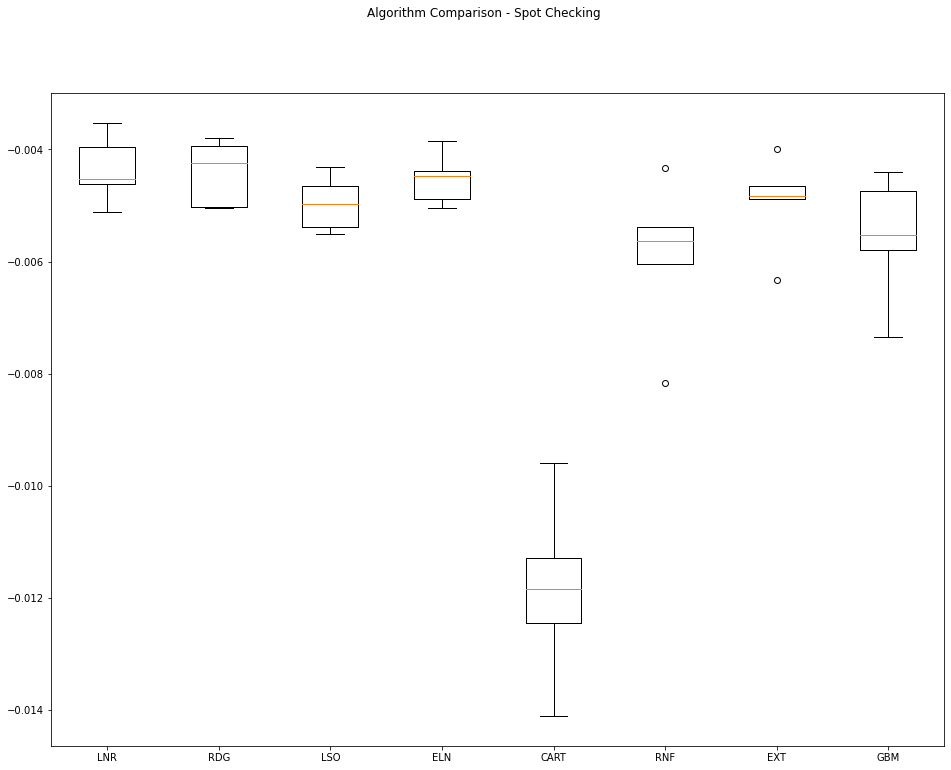

In [45]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [46]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [47]:
# Tuning algorithm #1 - Ridge Regression
startTimeModule = datetime.now()
if notifyStatus: email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model_names.append('RDG')
tune_model1 = Ridge(random_state=seedNum)
paramGrid1 = dict(alpha=np.array([0.1, 0.5, 0.75, 1.0, 2.0]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result1.best_score_*-1)))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: -0.004372 using {'alpha': 0.1}
-0.004372 (0.000494) with: {'alpha': 0.1}
-0.004386 (0.000512) with: {'alpha': 0.5}
-0.004398 (0.000525) with: {'alpha': 0.75}
-0.004408 (0.000534) with: {'alpha': 1.0}
-0.004430 (0.000555) with: {'alpha': 2.0}
Best RMSE for the Model is: 0.06611855072946518
Model training time: 0:00:01.481231


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [48]:
for key, value in grid_result1.best_params_.items():
    best_paramKey1 = key
    best_paramValue1 = value
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: alpha = 0.1


In [49]:
# Tuning algorithm #2 - Extra Trees
startTimeModule = datetime.now()
if notifyStatus: email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model_names.append('EXT')
tune_model2 = ExtraTreesRegressor(random_state=seedNum, n_jobs=n_jobs)
paramGrid2 = dict(n_estimators=np.array([50, 100, 200, 300, 500]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result2.best_score_*-1)))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: -0.004824 using {'n_estimators': 500}
-0.005144 (0.000761) with: {'n_estimators': 50}
-0.004938 (0.000763) with: {'n_estimators': 100}
-0.004839 (0.000821) with: {'n_estimators': 200}
-0.004844 (0.000849) with: {'n_estimators': 300}
-0.004824 (0.000828) with: {'n_estimators': 500}
Best RMSE for the Model is: 0.06945172589817554
Model training time: 0:00:05.919131


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.5s finished


In [50]:
for key, value in grid_result2.best_params_.items():
    best_paramKey2 = key
    best_paramValue2 = value
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 500


### 5.b) Compare Algorithms After Tuning

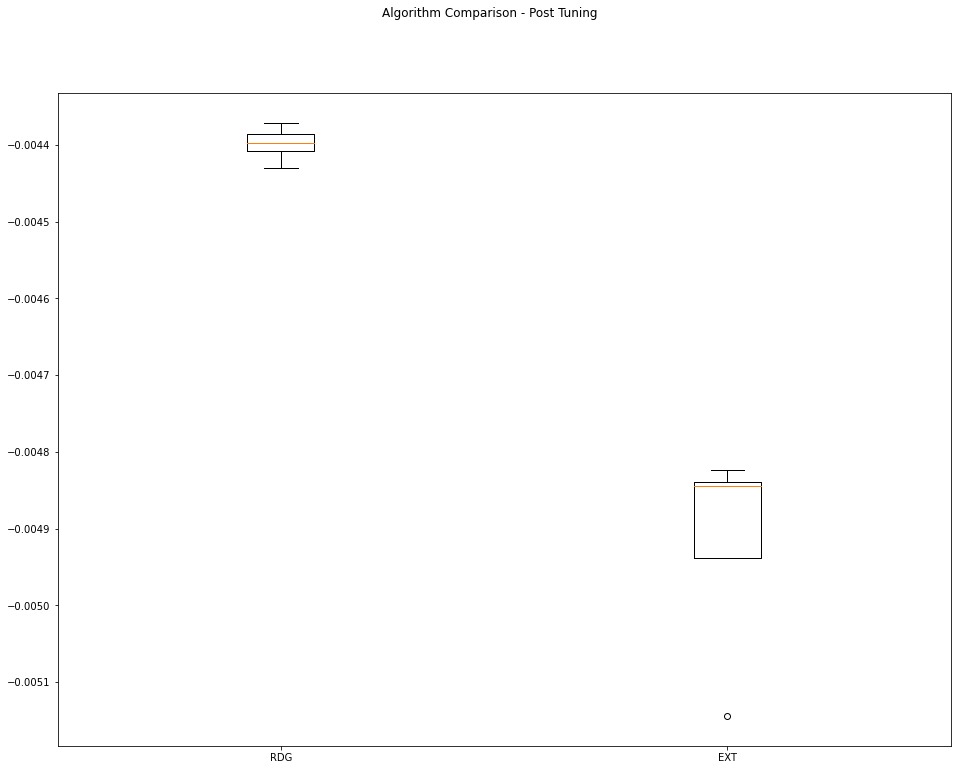

In [51]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [52]:
if notifyStatus: email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [53]:
test_model1 = Ridge(alpha=best_paramValue1, random_state=seedNum)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, predictions1)))
print('R2 for the model is: ', r2_score(y_test, predictions1))
print(test_model1)

RMSE for the model is:  0.06433650264544587
R2 for the model is:  0.8387615337603511
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=888, solver='auto', tol=0.001)


In [54]:
test_model2 = ExtraTreesRegressor(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs)
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, predictions2)))
print('R2 for the model is: ', r2_score(y_test, predictions2))
print(test_model2)

RMSE for the model is:  0.06896141191240482
R2 for the model is:  0.8147466586362818
ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=500, n_jobs=-1, oob_score=False,
                    random_state=888, verbose=0, warm_start=False)


### 6.b) Create a standalone model using all available data

In [55]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
# X_complete = np.vstack((X_train, X_test))
# y_complete = np.concatenate((y_train, y_test))
# print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
# final_model = test_model1.fit(X_complete, y_complete)
# print(final_model)

### 6.c) Save the final model for later use

In [56]:
# modelName = 'FinalModel_Regression.sav'
# dump(final_model, modelName)

In [57]:
if notifyStatus: email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:06.636182
